# Understanding convolution


In [1]:
from scipy import signal
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from wand.image import Image
from wand.display import display
from celluloid import Camera

In [4]:
sns.set(context='talk', style='ticks', palette='muted')

## simulate eye hand signals

In [5]:
def createSignal(
    amplitude,
    freqList, 
    lenSignal, 
    timePeriod, 
    burstFreq, 
    burstTime, 
    dc_offset,
    noise_level
):
    np.random.seed(seed=42)
    
    t = np.linspace(timePeriod[0], timePeriod[1], lenSignal)
    
    signal =  amplitude * np.sin(np.pi * 2. * burstFreq * t)
    
    signal[np.logical_or(t < burstTime[0], t > burstTime[1])] = 0
    
    on_time = np.logical_and(t >= burstTime[0], t <= burstTime[1])
    
    signal = signal + dc_offset + np.random.normal(noise_level, 1, size=lenSignal) 
    
#     signal[on_time] *= np.hanning(on_time.sum()) 
    
#     for f in freqList:
#         signal = signal + np.sin(2*np.pi*f*t)
        
    return signal

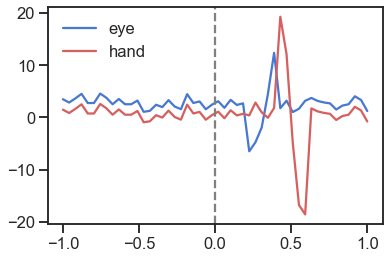

In [44]:
freqList = [1]
N = 50
noise_level = 2
timePeriod = [-1, 1]
t = np.linspace(*timePeriod, N)
burstFreq = 3
burstTime = [0.2, 0.4]
dc_offset = 1
amplitude = 10
x = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
plt.plot(t, x, color='b', label='eye')
burstFreq = 3
burstTime = [0.4, 0.6]
dc_offset = -1
amplitude = 20

y = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
plt.plot(t, y, color='r', label='hand')
plt.legend(frameon=False)

plt.axvline(0, color='grey', ls='--');

## Convolution using scipy.signal.convolve

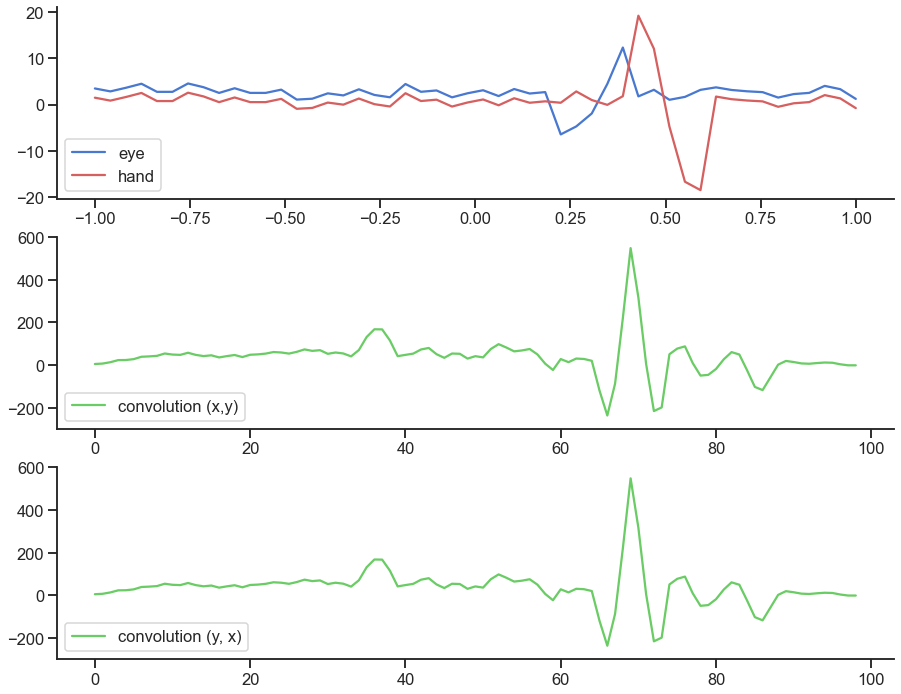

In [75]:
_, ax = plt.subplots(3, 1, figsize=(15,12))
ax = ax.ravel()

ax[0].plot(t, x, color='b', label='eye')
ax[0].plot(t, y, color='r', label='hand')

con = signal.convolve(x, y, mode='full', method='fft')

ax[1].plot(con, color='g', label='convolution (x,y)')
ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')

con = signal.convolve(y, x, mode='full', method='fft')

ax[2].plot(con, color='g', label='convolution (y, x)')
ax[2].legend(loc='lower left');

ax[1].set(ylim=(-300, 600))
ax[2].set(ylim=(-300, 600))
sns.despine()
# print(x.shape, corr.shape)

## Compute convolution using fft

In [76]:
def convolve_fft(x, y):
    nconv = len(x) + len(y) - 1
    x1 = fft(x, nconv)
    y1 = fft(y, nconv)
    con = np.real(ifft(x1 * y1))
    return con

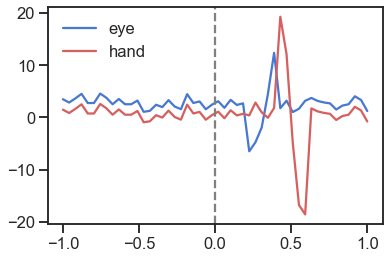

In [77]:
freqList = [1]
N = 50
noise_level = 2
timePeriod = [-1, 1]
t = np.linspace(*timePeriod, N)
burstFreq = 3
burstTime = [0.2, 0.4]
dc_offset = 1
amplitude = 10
x = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
plt.plot(t, x, color='b', label='eye')
burstFreq = 3
burstTime = [0.4, 0.6]
dc_offset = -1
amplitude = 20

y = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
plt.plot(t, y, color='r', label='hand')
plt.legend(frameon=False)

plt.axvline(0, color='grey', ls='--');


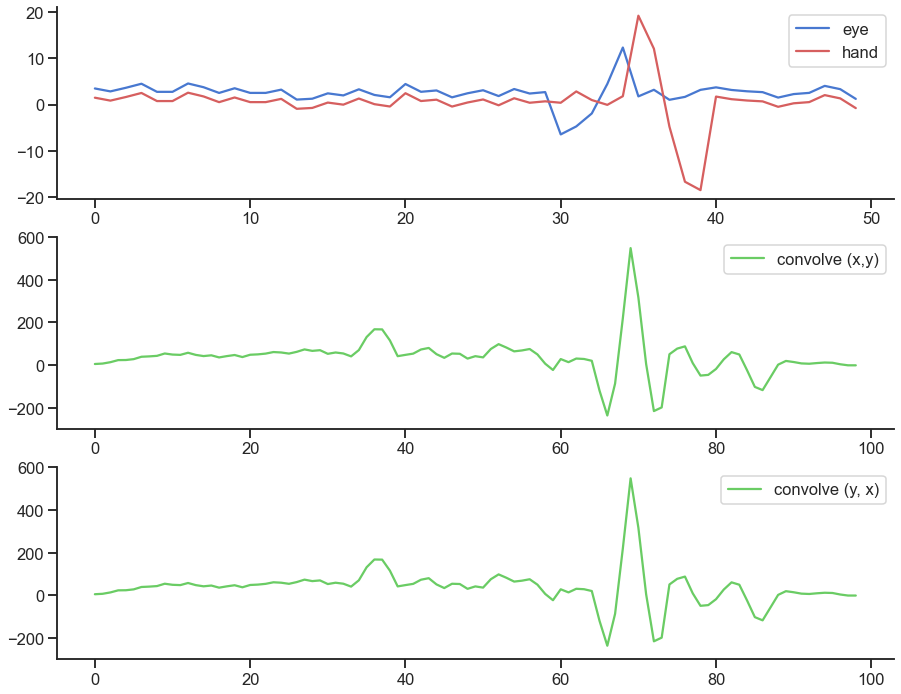

In [78]:
_, ax = plt.subplots(3, 1, figsize=(15,12), sharey=False)
ax = ax.ravel()

con = convolve_fft(x, y)
ax[0].plot(x, color='b', label='eye')
ax[0].plot(y, color='r', label='hand')
ax[1].plot(con, color='g', label='convolve (x,y)')
ax[0].legend()
ax[1].legend()

con = convolve_fft(y, x)
ax[2].plot(con, color='g', label='convolve (y, x)')
ax[2].legend()
ax[1].set(ylim=(-300, 600))
ax[2].set(ylim=(-300, 600))

sns.despine()

Switching signals gives mirrored cross-corr

## Animated XCorr

In [101]:
def get_signal(N):
    freqList = [1]
#     N = 50
    noise_level = 2
    timePeriod = [-1, 1]
    t = np.linspace(*timePeriod, N)
    burstFreq = 3
    burstTime = [0.2, 0.4]
    dc_offset = 1
    amplitude = 10
    
    x = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
    
    burstFreq = 3
    burstTime = [0.4, 0.6]
    dc_offset = -1
    amplitude = 20

    y = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
    
    return x, y, t

def get_conv(x, y):  
    
    Rxy_tau = (x * y).sum()
        
    return Rxy_tau

def convolve():
    # create signals     
    x, y, t = get_signal(60)
    
    
    assert len(x) == len(y)
    N = len(x)
    
    # pad the main signal    
    padded_x = np.pad(x, (N, 2*N), 'constant')
    
    y1 = y[::-1]
    conv = np.array([])
    for idx, tau in enumerate(range(N, 3*N, 1)):      
        padded_y = np.pad(y1, (idx, 3*N - idx), 'constant')
        conv = np.append(
            conv, 
            get_conv(
                padded_x[:tau], padded_y[:tau]
            )
        )
    
    return padded_x, y1, conv, t, N
    

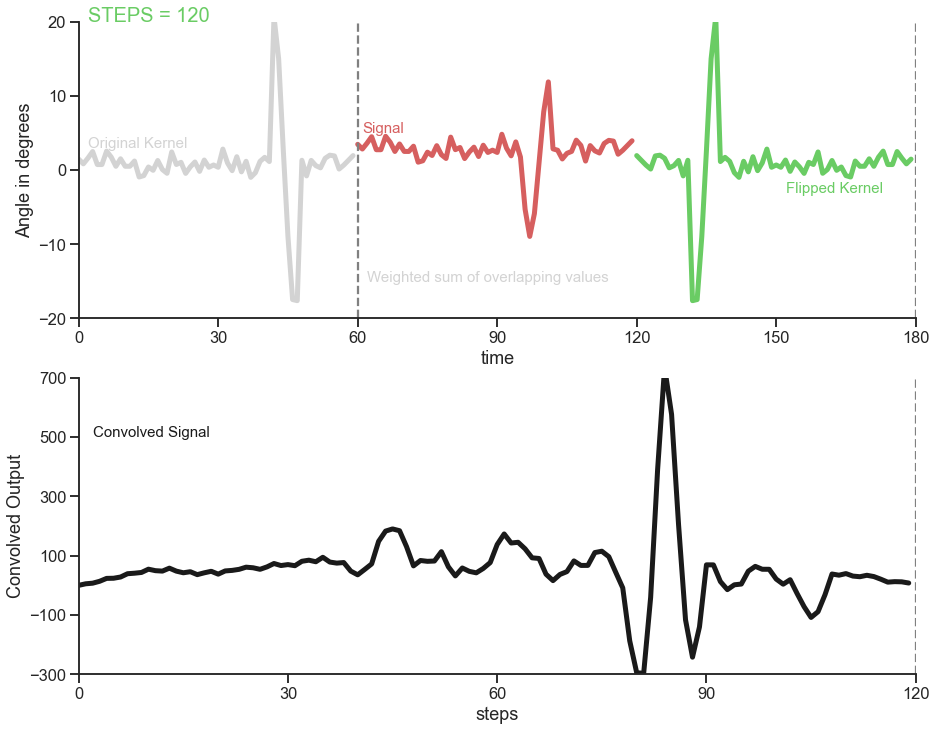

In [107]:
fig, axes = plt.subplots(2, 1, figsize=(15,12), sharex=False)
# fig.subplots_adjust(hspace=2)
camera = Camera(fig)

x, y , conv, t, N = convolve()


for ind, ax in enumerate(axes):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#         ax.legend()
        if ind != 1:
            ax.set(ylim=(-20,20), xlim=(0,3*N), 
                   yticks=np.arange(-20,21,10), 
                   xticks=np.arange(0,3*N + 1, N/2.),
                   xlabel='time',
                   ylabel='Angle in degrees'
                  )
        else:
            ax.set(ylim=(-300,600), xlim=(0,2*N), 
                   yticks=np.arange(-300, 800, 200), 
                   xticks=np.arange(0,2*N + 1, N/2.),
                   xlabel='steps',
                   ylabel='Convolved Output'
                  )



for frame in range(2*N + 1):   
    
    x[x==0] = np.nan
    axes[0].plot(x, color='r', lw=5 )
    
    axes[0].axvline(frame + N, color='grey', ls='--')
    axes[0].axvline(N, color='grey', ls='--')
    
    padded_y = np.pad(y, (frame, 3*N - frame), 'constant', constant_values=np.nan)
    axes[0].plot(y[::-1], color='lightgrey', lw=5 )
    axes[0].plot(padded_y, color='g', lw=5, )
    
    axes[0].text(    
        2, 20, f'STEPS = {frame}', {'color': 'g', 'fontsize': 20},
    )
    axes[0].text(    
        2, 3, f'Original Kernel', {'color': 'lightgrey', 'fontsize': 15},
    )
    axes[0].text(    
        frame + 32, -3, f'Flipped Kernel', {'color': 'g', 'fontsize': 15},
    )
    axes[0].text(    
        61, 5, f'Signal', {'color': 'r', 'fontsize': 15},
    )
    axes[0].text(    
        N + 2, -15, r'Weighted sum of overlapping values', {'color': 'lightgrey', 'fontsize': 15},
    )
    axes[1].text(    
        2, 500, f'Convolved Signal', {'color': 'k', 'fontsize': 15},
    )
    

    axes[1].plot(conv[:frame], color='k', lw=5,)
    axes[1].axvline(frame, color='grey', ls='--')    
    
    camera.snap()

animation = camera.animate(interval = 1000,)
animation.save('convolution.gif')


## SCRATCH

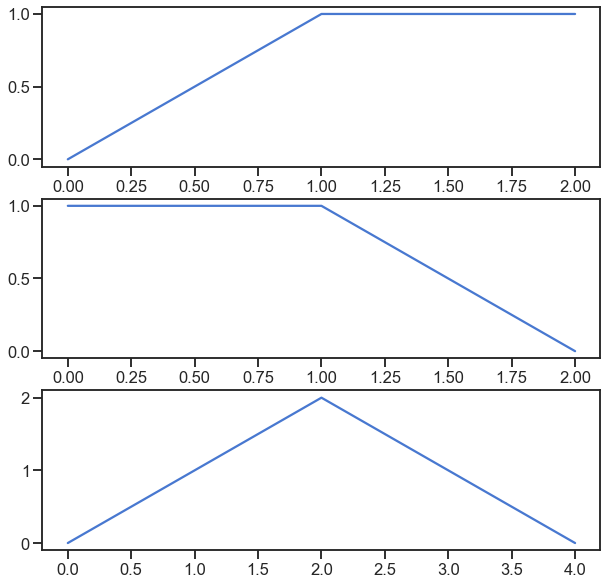

In [90]:
a = [0, 1, 1,]# 0, 0, 0, 2, 2, 2, 0]

b = [1, 1, 0,]# 0, 1, 2, 2, 1, 0, 0]

conv = signal.convolve(a, b)

_, ax = plt.subplots(3, 1, sharex=False, figsize=(10,10))

ax[0].plot(a)
ax[1].plot(b)
ax[2].plot(conv)